# Fraud Detection Analysis and Prediction with ML Classifers

DATA SOURCE: https://www.kaggle.com/ealaxi/paysim1

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* amount -amount of the transaction in local currency.
* nameOrig - customer who started the transaction
* oldbalanceOrg - initial balance before the transaction
* newbalanceOrig - new balance after the transaction
* nameDest - customer who is the recipient of the transaction
* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import auc,roc_curve

In [148]:
df = pd.read_csv("datasets/sampled_aml_df_3.csv")
df.head()

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1577509,155,CASH_OUT,427818.23,C1431817875,198219.00,0.00,C2131020093,0.00,427818.23,0,0
1,3869859,283,CASH_IN,68154.77,C397915380,2884459.21,2952613.98,C105277746,1030035.29,961880.52,0,0
2,5516324,380,CASH_OUT,80828.54,C809484944,0.00,0.00,C226553176,5149991.49,5230820.04,0,0
3,5490462,380,TRANSFER,106069.89,C1857104283,301258.00,195188.11,C1759851095,263816.83,369886.72,0,0
4,5606765,394,PAYMENT,34530.86,C1774638089,200755.00,166224.14,M1074240731,0.00,0.00,0,0


In [149]:
df.shape

(192500, 12)

In [150]:
# Check for missing values
df.isnull().sum().sum()

0

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192500 entries, 0 to 192499
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           192500 non-null  int64  
 1   step            192500 non-null  int64  
 2   type            192500 non-null  object 
 3   amount          192500 non-null  float64
 4   nameOrig        192500 non-null  object 
 5   oldbalanceOrg   192500 non-null  float64
 6   newbalanceOrig  192500 non-null  float64
 7   nameDest        192500 non-null  object 
 8   oldbalanceDest  192500 non-null  float64
 9   newbalanceDest  192500 non-null  float64
 10  isFraud         192500 non-null  int64  
 11  isFlaggedFraud  192500 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 17.6+ MB


# Data Analysis

In [152]:
# Investigate identifier columns (large number of unique values = not much predictive power)
print(df["nameOrig"].nunique())
print(df["nameDest"].nunique())

192494
168929


In [153]:
# Drop columns not required
df.drop(["nameOrig","nameDest","index"],axis = 1, inplace = True)

In [154]:
df.sample(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
124810,331,CASH_OUT,95824.94,29711.00,0.00,0.00,95824.94,0,0
128040,329,CASH_IN,285784.29,15765528.04,16051312.33,1339199.64,1098552.39,0,0
61892,40,CASH_OUT,215841.88,0.00,0.00,1375232.40,1591074.28,0,0
156156,328,CASH_OUT,327842.46,25946.00,0.00,0.00,327842.46,0,0
178354,258,PAYMENT,10313.28,7239.00,0.00,0.00,0.00,0,0


In [155]:
df.describe(include = ["float"])

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,1.925000e+05,1.925000e+05,1.925000e+05,1.925000e+05,1.925000e+05
mean,2.261676e+05,8.616604e+05,8.270867e+05,1.084274e+06,1.230771e+06
std,7.720697e+05,2.912266e+06,2.887263e+06,3.297716e+06,3.575349e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.401661e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.060089e+04,1.696019e+04,0.000000e+00,1.144710e+05,2.091728e+05
75%,2.188217e+05,1.336372e+05,1.290969e+05,9.127214e+05,1.115385e+06
max,6.988673e+07,5.958504e+07,4.958504e+07,2.511150e+08,2.506381e+08


## How many items are labelled as fraudulent?

In [156]:
df["isFraud"].value_counts()

0    185000
1      7500
Name: isFraud, dtype: int64

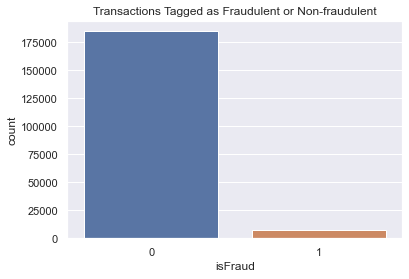

In [157]:
sns.countplot(data = df, x = "isFraud")
plt.title("Transactions Tagged as Fraudulent or Non-fraudulent");

Dataset is very unbalanced

## How many items are flagged as fraud in the dataset?

In [158]:
df["isFlaggedFraud"].value_counts()

0    192484
1        16
Name: isFlaggedFraud, dtype: int64

Very few items flagged as fraud by the bank system based on the size of transactions

## Comparison of Flagged and Non-Flagged Transactions by whether they are Fraudulent

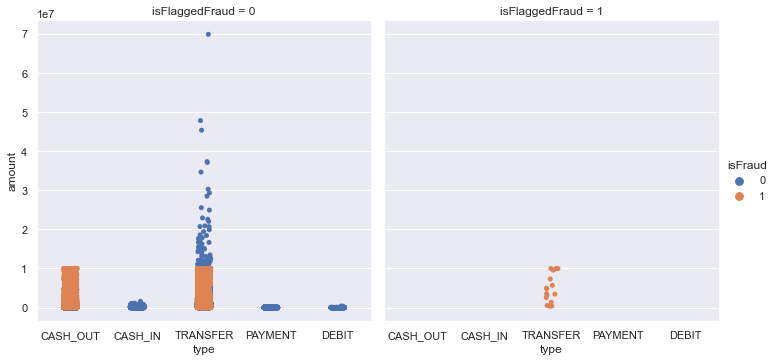

In [159]:
sns.catplot(data = df, x = "type", y = "amount", hue = "isFraud",col = "isFlaggedFraud");

* For those were not flagged as fraud by the bank but were fraudulent, most were cash_out or transfers
* For fraudulent transactions that were labelled by the bank as such, all were transfers.
* With so few fraudulent items flagged by the system, this feature is not useful for prediction and can be dropped

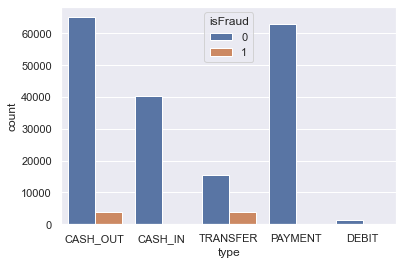

In [160]:
sns.countplot(data = df, x = "type", hue = "isFraud");

The fraudulent transactions are either cash out or transfers

In [161]:
df.drop(columns = ["isFlaggedFraud"],axis = 1, inplace = True)

In [162]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,155,CASH_OUT,427818.23,198219.00,0.00,0.00,427818.23,0
1,283,CASH_IN,68154.77,2884459.21,2952613.98,1030035.29,961880.52,0
2,380,CASH_OUT,80828.54,0.00,0.00,5149991.49,5230820.04,0
3,380,TRANSFER,106069.89,301258.00,195188.11,263816.83,369886.72,0
4,394,PAYMENT,34530.86,200755.00,166224.14,0.00,0.00,0


## Transactions over Time

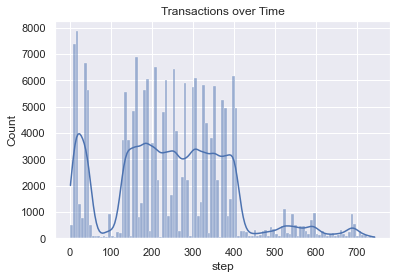

In [163]:
sns.histplot(data = df, x = "step", kde = True)
plt.title("Transactions over Time");

The simulation was run over 30 days (1 month) with each step representing one hour of time.

Most transactions occur at the start of the period then drop and rise again mid-way through. Towards the end of the period, the number of transactions is relatively low.


### How does the pattern look over periods of 24 hours?

In [164]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,155,CASH_OUT,427818.23,198219.00,0.00,0.00,427818.23,0
1,283,CASH_IN,68154.77,2884459.21,2952613.98,1030035.29,961880.52,0
2,380,CASH_OUT,80828.54,0.00,0.00,5149991.49,5230820.04,0
3,380,TRANSFER,106069.89,301258.00,195188.11,263816.83,369886.72,0
4,394,PAYMENT,34530.86,200755.00,166224.14,0.00,0.00,0


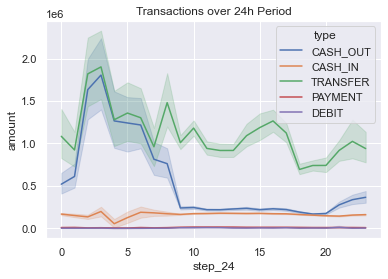

In [165]:
# Get daily value of the step (for each hour of the day) and plot by transaction
df["step_24"] = df["step"]%24
sns.lineplot(data = df, x = "step_24", y = "amount", hue = "type")
plt.title("Transactions over 24h Period");

The cash out and transfer transactions where most fraudulent activity occurs, happen early on in the day between 1am and 4am

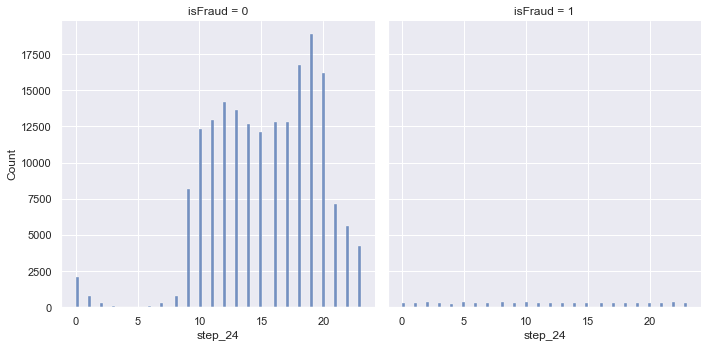

In [166]:
sns.displot(data = df, x = "step_24", col = "isFraud");

Non-fraudulent transactions tend to vary during the day whereas the fraudulent transactions are evenly spread

In [167]:
# Focus on the two categories where fraudulent transactions occur - cash out and transfers
df2 = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [168]:
df2.shape

(87998, 9)

In [169]:
# One hot encode the type column and concat back to the original dataframe
cats = pd.get_dummies(df2["type"], drop_first = True)
cats.head()

,TRANSFER
0,0
2,0
3,1
6,0
12,0


In [170]:
df2 = pd.concat([df2,cats],axis = 1)
#df2.drop(columns = ["type"],axis = 2,inplace = True)

In [171]:
# Recheck the balance between fraudulent and non-fraudulent transactions
df["isFraud"].value_counts()

0    185000
1      7500
Name: isFraud, dtype: int64

# Feature Engineering

In [172]:
df2.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'step_24', 'TRANSFER'],
      dtype='object')

In [173]:
# Create new features
df2["ErrorOrig"] = df2["newbalanceOrig"] + df2["amount"] - df2["oldbalanceOrg"]
df2["ErrorDest"] = df2["oldbalanceDest"] + df2["amount"] - df2["newbalanceDest"]

In [174]:
df2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,step_24,TRANSFER,ErrorOrig,ErrorDest
0,155,CASH_OUT,427818.23,198219.0,0.00,0.00,427818.23,0,11,0,229599.23,0.000000e+00
2,380,CASH_OUT,80828.54,0.0,0.00,5149991.49,5230820.04,0,20,0,80828.54,-1.000000e-02
3,380,TRANSFER,106069.89,301258.0,195188.11,263816.83,369886.72,0,20,1,0.00,5.820766e-11
6,306,CASH_OUT,402832.90,11665.0,0.00,28550.98,431383.87,0,18,0,391167.90,1.000000e-02
12,382,CASH_OUT,34643.49,0.0,0.00,346081.41,380724.90,0,22,0,34643.49,-5.820766e-11


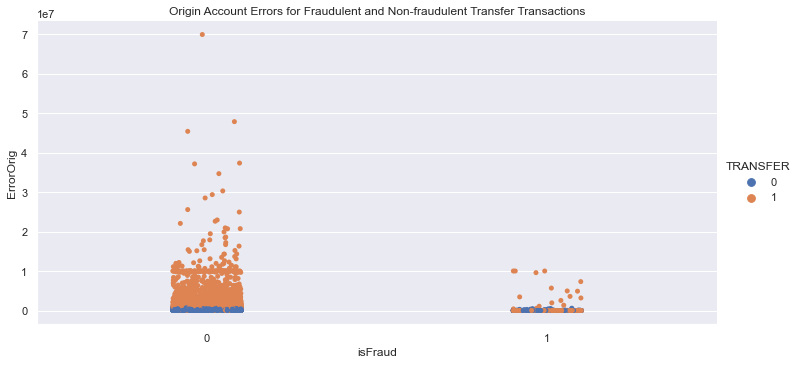

In [179]:
sns.catplot(data = df2, x = "isFraud", y = "ErrorOrig", hue = "TRANSFER", aspect = 2, estimator = sum)
plt.title("Origin Account Errors for Fraudulent and Non-fraudulent Transfer Transactions");

The graph shows that there is no clear patterns, there are discrepancies in the balances on the origin account for both fraudulent and non-fraudulent accounts

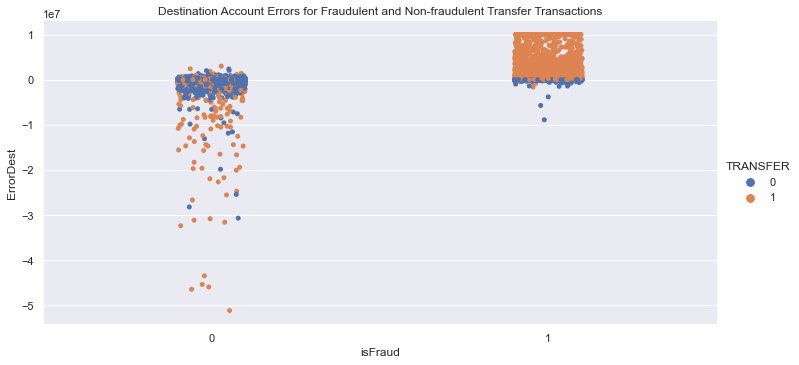

In [180]:
sns.catplot(data = df2, x = "isFraud", y = "ErrorDest", hue = "TRANSFER", aspect = 2, estimator = sum)
plt.title("Destination Account Errors for Fraudulent and Non-fraudulent Transfer Transactions");

There is a significant different in destination account errors between fraudulent and non-fraudulent transfer transactions. 

# Build Classification Models

In [185]:
X = df2.drop(["isFraud", "type"],axis = 1)
y = df2["isFraud"]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [188]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70398, 10) (17600, 10) (70398,) (17600,)


In [198]:
# Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred1 = lr.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(recall_score(y_test, y_pred1))

0.9640909090909091
0.8308880308880309
0.722632639355272


* Accuracy is not the  best metric due to skew
* Precision - of the positive fraudulent identifications around 80 percent were correct
* Recall - of all the fraudulent transactions, around 72 percent were correct

In [199]:
# Naive Bayes using conditional probabilities
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred2 = nb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))

0.9425568181818181
0.8545994065281899
0.38683680322364


This model does very poorly at finding the fraudulent transactions

In [200]:
# Support vector Classifier
svm = SVC()
svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(recall_score(y_test, y_pred3))

0.9641477272727272
0.9809417040358744
0.587642713230356


The recall is still not very high

In [203]:
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred4 = rf.predict(X_test)
print(accuracy_score(y_test, y_pred4))
print(precision_score(y_test, y_pred4))
print(recall_score(y_test, y_pred4))

0.9996022727272728
0.9986541049798116
0.9966420416386836


This gives the best results of all the models

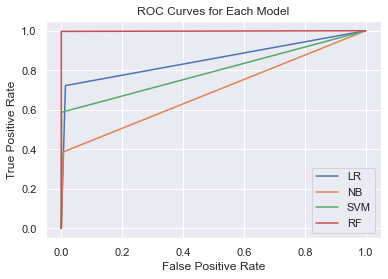

In [226]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred1)
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred2)
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred3)
fpr4, tpr4, threshold4 = roc_curve(y_test, y_pred4)

plt.plot(fpr1, tpr1, label = "LR")
plt.plot(fpr2, tpr2, label = "NB")
plt.plot(fpr3, tpr3, label = "SVM")
plt.plot(fpr4, tpr4, label = "RF")

plt.legend()
plt.title("ROC Curves for Each Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");

In [ ]:
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

In [224]:
print(roc_auc1, roc_auc3, roc_auc3, roc_auc4)

0.8545197210804043 0.7932937667697307 0.7932937667697307 0.9982589514257598


The Random Forest Classifier Model is the preferred model for this data